In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Layer
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_yaml
from modAL.models import ActiveLearner
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.backend import eager_learning_phase_scope
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_chns, img_rows, img_cols)

In [4]:
(x_tr, y_tr), (x_te, y_te) = cifar10.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.

In [6]:
x_tr = x_tr.reshape((x_tr.shape[0],) + original_img_size)
x_te = x_te.reshape((x_te.shape[0],) + original_img_size)

In [7]:
BATCH_SIZE = 128
ORIGINAL_DIM = 784
HIDDEN_DIM = 512
EPOCH = 50
epsilon_std = 1.0
LATENT_DIMS = [64]
LATENT_DIM = 256
latent_dim = 256
intermediate_dim = 1024
usecuda=False
USE_CUDA = False
DEVICE   = ('cuda' if USE_CUDA else 'cpu')

In [8]:
from torchsummary import summary

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 =  nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.layer2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.layer3 = nn.Flatten()
        self.layer4 = nn.Linear(4096, 1024)
        self.layer5 = nn.Linear(1024, latent_dim)
    
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h1 = self.relu(self.layer1(x))
        h2 = self.relu(self.layer2(h1))
        h3 = self.layer3(h2)
        h4 = self.relu(self.layer4(h3))
        h5 = self.relu(self.layer5(h4))
        
        return h5
        
encodermodel = Encoder()
if usecuda:
    encodermodel.cuda(idgpu)       
summary(encodermodel, (3, 32, 32))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
           Flatten-5                 [-1, 4096]               0
            Linear-6                 [-1, 1024]       4,195,328
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
              ReLU-9                  [-1, 256]               0
Total params: 4,477,120
Trainable params: 4,477,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.24
Params size (MB): 17.08
Estimated Total Size (MB): 17.33
-------------------------------------

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Linear(latent_dim, 1024)
        self.layer2 = nn.Linear(1024, 4096)
        self.layer3 = nn.Unflatten(1, torch.Size([64, 8, 8]))
        self.layer4 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.layer5 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.layer6 = nn.ConvTranspose2d(32, 3, 3, padding=1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,z):
        h1 = self.relu(self.layer1(z))
        h2 = self.relu(self.layer2(h1))
        h3 = self.layer3(h2)
        h4 = self.relu(self.layer4(h3))
        h5 = self.relu(self.layer5(h4))
        h6 = self.sigmoid(self.layer6(h5))
        
        return h6
        
decodermodel = Decoder()
if usecuda:
    decodermodel.cuda(idgpu)  
    
summary(decodermodel, (256,))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         263,168
              ReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 4096]       4,198,400
              ReLU-4                 [-1, 4096]               0
         Unflatten-5             [-1, 64, 8, 8]               0
   ConvTranspose2d-6           [-1, 64, 16, 16]          65,600
              ReLU-7           [-1, 64, 16, 16]               0
   ConvTranspose2d-8           [-1, 32, 32, 32]          32,800
              ReLU-9           [-1, 32, 32, 32]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]             867
          Sigmoid-11            [-1, 3, 32, 32]               0
Total params: 4,560,835
Trainable params: 4,560,835
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [11]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [12]:
class MMDVAE(torch.nn.Module):
    def __init__(self):
        super(MMDVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [13]:
n_show = 10

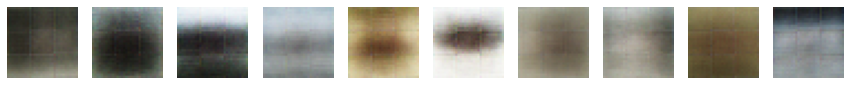

Epoch:  0
Negative log likelihood is 0.02220, mmd loss is 0.00018


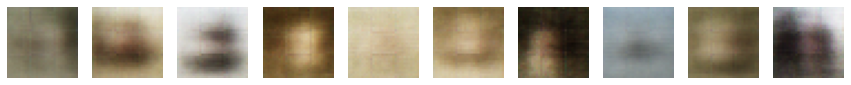

Epoch:  1
Negative log likelihood is 0.02074, mmd loss is 0.00019


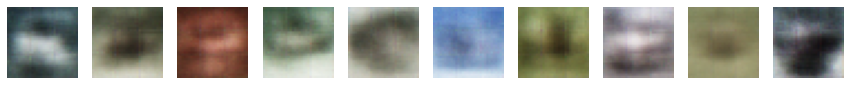

Epoch:  2
Negative log likelihood is 0.01834, mmd loss is 0.00023


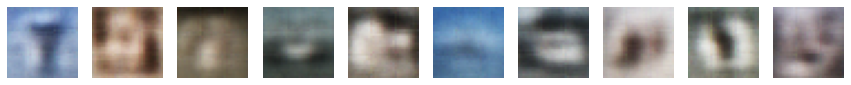

Epoch:  3
Negative log likelihood is 0.01420, mmd loss is 0.00022


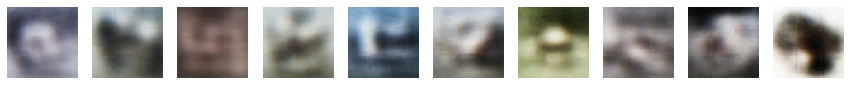

Epoch:  4
Negative log likelihood is 0.01273, mmd loss is 0.00023


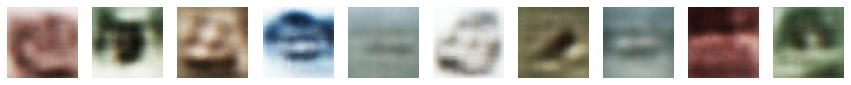

Epoch:  5
Negative log likelihood is 0.01177, mmd loss is 0.00021


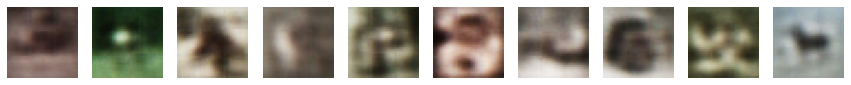

Epoch:  6
Negative log likelihood is 0.01075, mmd loss is 0.00020


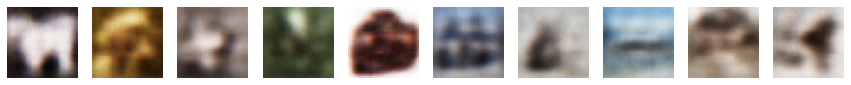

Epoch:  7
Negative log likelihood is 0.01078, mmd loss is 0.00021


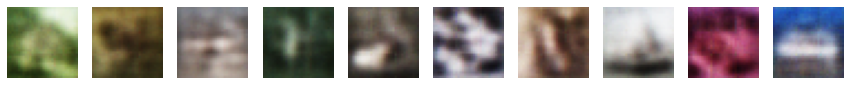

Epoch:  8
Negative log likelihood is 0.00996, mmd loss is 0.00021


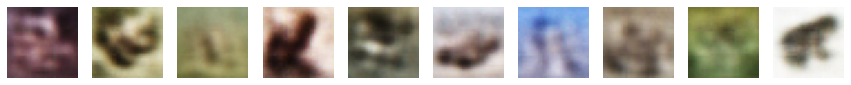

Epoch:  9
Negative log likelihood is 0.01100, mmd loss is 0.00019


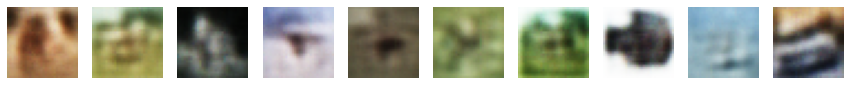

Epoch:  10
Negative log likelihood is 0.00915, mmd loss is 0.00020


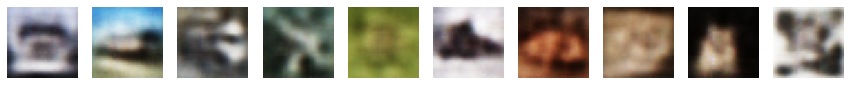

Epoch:  11
Negative log likelihood is 0.00966, mmd loss is 0.00020


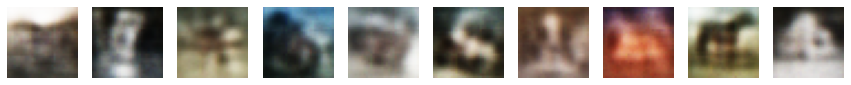

Epoch:  12
Negative log likelihood is 0.00874, mmd loss is 0.00018


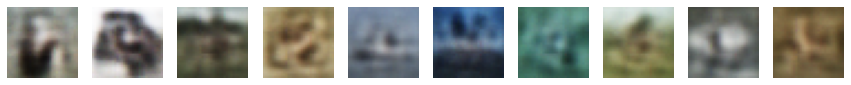

Epoch:  13
Negative log likelihood is 0.00836, mmd loss is 0.00017


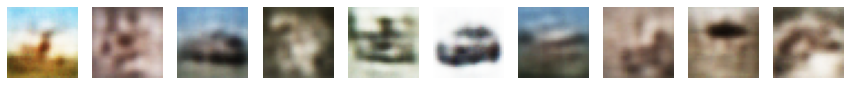

Epoch:  14
Negative log likelihood is 0.00939, mmd loss is 0.00018


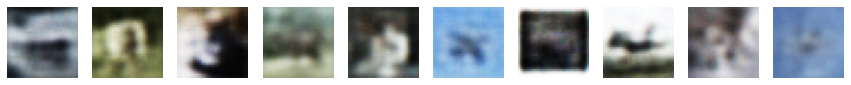

Epoch:  15
Negative log likelihood is 0.00796, mmd loss is 0.00021


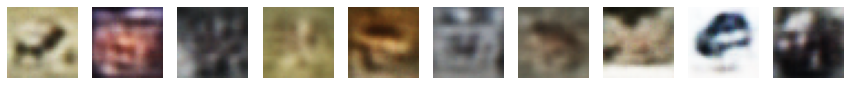

Epoch:  16
Negative log likelihood is 0.00811, mmd loss is 0.00019


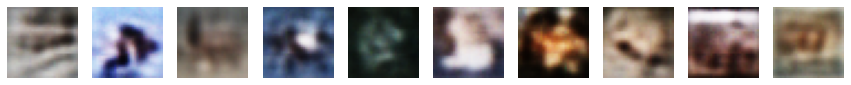

Epoch:  17
Negative log likelihood is 0.00857, mmd loss is 0.00020


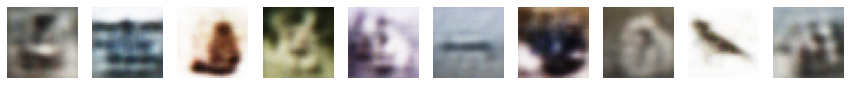

Epoch:  18
Negative log likelihood is 0.00743, mmd loss is 0.00018


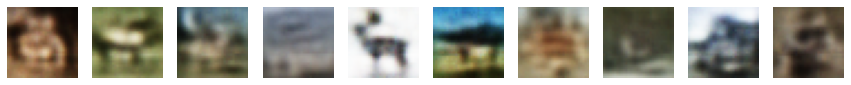

Epoch:  19
Negative log likelihood is 0.00830, mmd loss is 0.00017


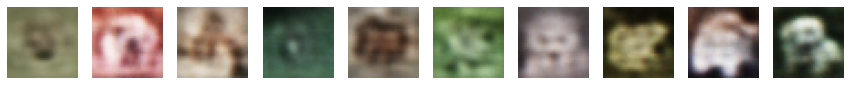

Epoch:  20
Negative log likelihood is 0.00816, mmd loss is 0.00018


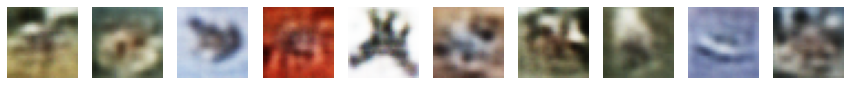

Epoch:  21
Negative log likelihood is 0.00824, mmd loss is 0.00016


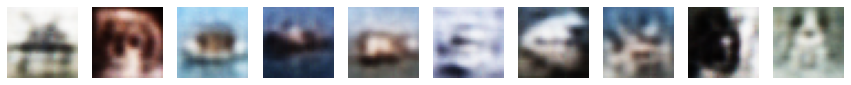

Epoch:  22
Negative log likelihood is 0.00746, mmd loss is 0.00019


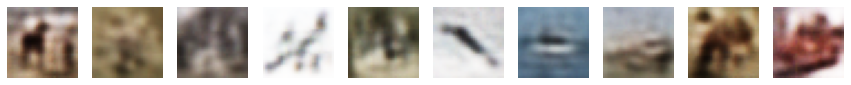

Epoch:  23
Negative log likelihood is 0.00690, mmd loss is 0.00016


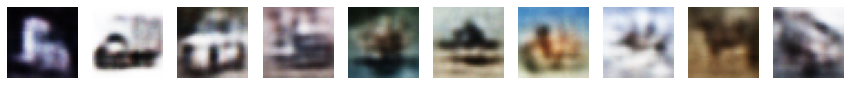

Epoch:  24
Negative log likelihood is 0.00816, mmd loss is 0.00017


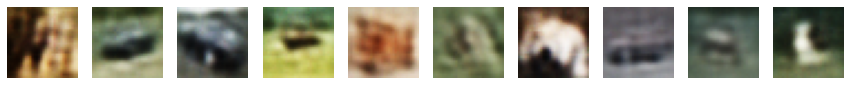

Epoch:  25
Negative log likelihood is 0.00675, mmd loss is 0.00017


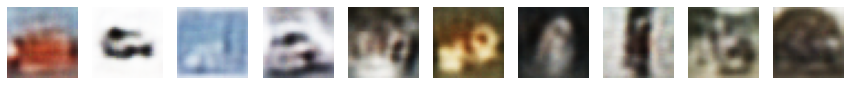

Epoch:  26
Negative log likelihood is 0.00657, mmd loss is 0.00018


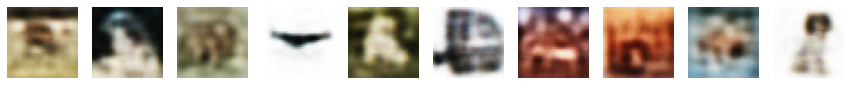

Epoch:  27
Negative log likelihood is 0.00826, mmd loss is 0.00017


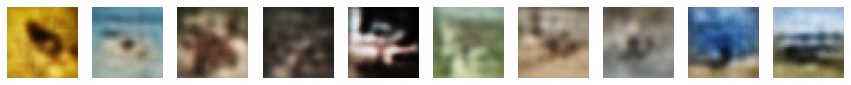

Epoch:  28
Negative log likelihood is 0.00707, mmd loss is 0.00016


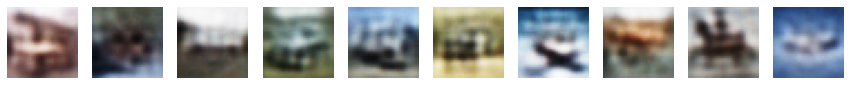

Epoch:  29
Negative log likelihood is 0.00661, mmd loss is 0.00017


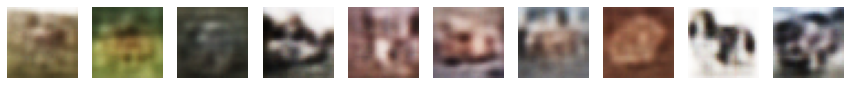

Epoch:  30
Negative log likelihood is 0.00627, mmd loss is 0.00016


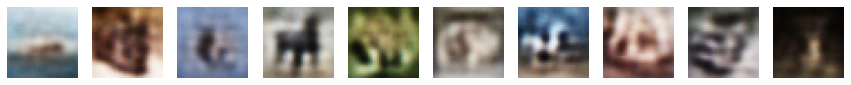

Epoch:  31
Negative log likelihood is 0.00680, mmd loss is 0.00015


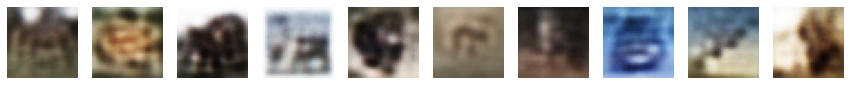

Epoch:  32
Negative log likelihood is 0.00662, mmd loss is 0.00015


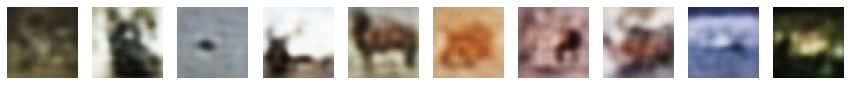

Epoch:  33
Negative log likelihood is 0.00673, mmd loss is 0.00018


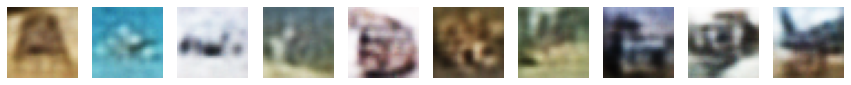

Epoch:  34
Negative log likelihood is 0.00698, mmd loss is 0.00014


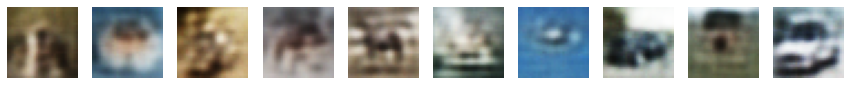

Epoch:  35
Negative log likelihood is 0.00707, mmd loss is 0.00017


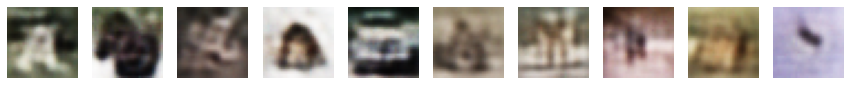

Epoch:  36
Negative log likelihood is 0.00646, mmd loss is 0.00016


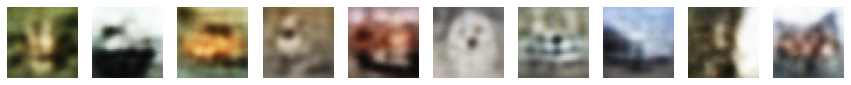

Epoch:  37
Negative log likelihood is 0.00698, mmd loss is 0.00015


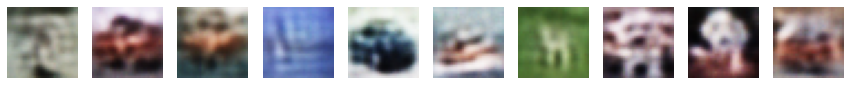

Epoch:  38
Negative log likelihood is 0.00646, mmd loss is 0.00014


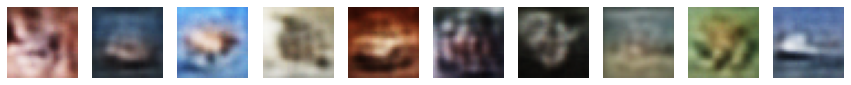

Epoch:  39
Negative log likelihood is 0.00661, mmd loss is 0.00015


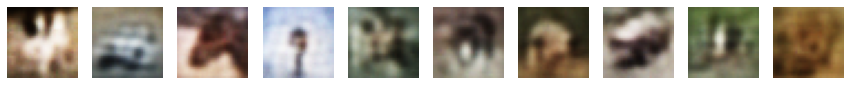

Epoch:  40
Negative log likelihood is 0.00744, mmd loss is 0.00014


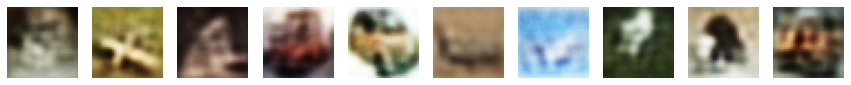

Epoch:  41
Negative log likelihood is 0.00683, mmd loss is 0.00014


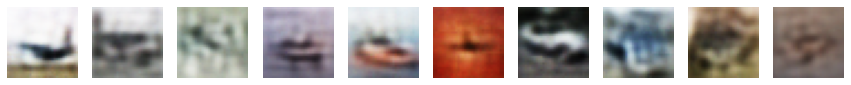

Epoch:  42
Negative log likelihood is 0.00643, mmd loss is 0.00015


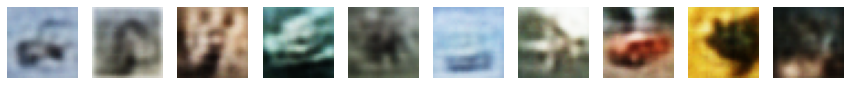

Epoch:  43
Negative log likelihood is 0.00651, mmd loss is 0.00015


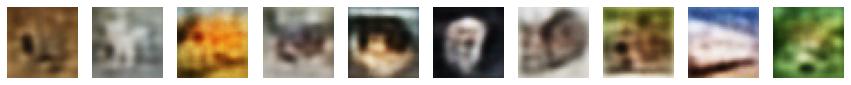

Epoch:  44
Negative log likelihood is 0.00823, mmd loss is 0.00018


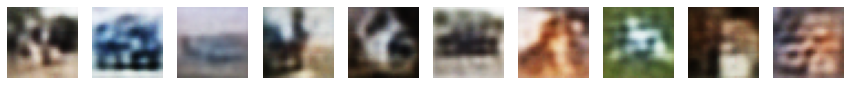

Epoch:  45
Negative log likelihood is 0.00632, mmd loss is 0.00015


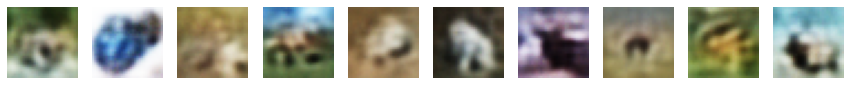

Epoch:  46
Negative log likelihood is 0.00620, mmd loss is 0.00015


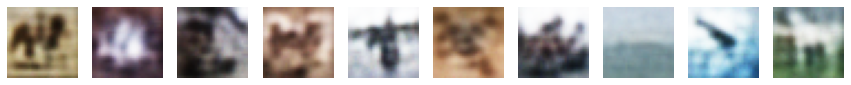

Epoch:  47
Negative log likelihood is 0.00729, mmd loss is 0.00015


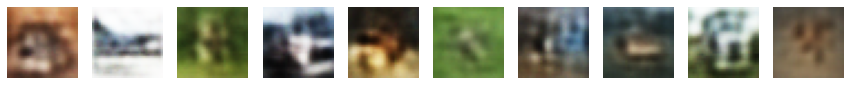

Epoch:  48
Negative log likelihood is 0.00627, mmd loss is 0.00017


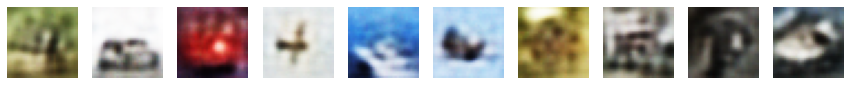

Epoch:  49
Negative log likelihood is 0.00679, mmd loss is 0.00016


In [14]:
model = MMDVAE()
optimizer = torch.optim.Adam(model.parameters())

for j in range(EPOCH):
    model.train()
    
    training_loss = 0
    training_reconstruction_error = 0
    training_mmd = 0
    batchnum = 0
    
    train_indices = np.arange(0, x_tr.shape[0])
    np.random.shuffle(train_indices)
    
    for i in range(0, len(x_tr), BATCH_SIZE): 
        batchnum = batchnum + 1
        end = i + BATCH_SIZE
        if (end > len(x_tr)):
            end = len(x_tr)
        train_x = Variable(torch.from_numpy(x_tr[train_indices[i:end]]), requires_grad=False)
           
        true_samples = torch.randn((len(train_x),latent_dim))
        true_samples = Variable(true_samples, requires_grad=False)
        
        optimizer.zero_grad()
        
        z, x_reconstructed = model(train_x)
        mmd = compute_mmd(true_samples, z)
        nll = (x_reconstructed - train_x).pow(2).mean()
        loss = nll + mmd
        loss.backward()
        optimizer.step()
        
    model.eval()
    gener = x_reconstructed[:n_show].detach().numpy().reshape(n_show, 32, 32, 3)
    fig, ax = plt.subplots(1, n_show, figsize=(15,5))
    for i in range(n_show):
        ax[i].imshow(gener[i], cmap='gray')
        ax[i].axis('off')
    plt.show()
    print("Epoch: ", j)
    print("Negative log likelihood is {:.5f}, mmd loss is {:.5f}".format(
        nll.data, mmd.data))

In [19]:
model.eval()

X_train_enhanced = np.zeros((x_tr.shape[0], LATENT_DIM), dtype="float32")

for ind, (x_point, y_point) in enumerate(zip(x_tr, y_tr)):
    x_point = x_point.reshape((1,) + original_img_size)
    z_point, _ = model(Variable(torch.from_numpy(x_point), requires_grad=False))
    X_train_enhanced[ind] = z_point.detach().numpy()
                       
X_test_enhanced = np.zeros((x_te.shape[0], LATENT_DIM), dtype="float32")
for ind, (x_point, y_point) in enumerate(zip(x_te, y_te)):
    x_point = x_point.reshape((1,) + original_img_size)
    z_point, _ = model(Variable(torch.from_numpy(x_point), requires_grad=False))
    X_test_enhanced[ind] = z_point.detach().numpy()

In [22]:
np.save('x_train_enhanced_infovae.npy', X_train_enhanced)
np.save('x_test_enhanced_infovae.npy', X_test_enhanced)

In [ ]:
torch.save(model.state_dict(), "infovae.pth")

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(X_train_enhanced)

In [ ]:
plt.figure(figsize=(15,10))
plt.title("tSNE of Latent Space Extracted by MMDVAE")
plt.rcParams.update({'font.size': 30})
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']

for i, c in zip(list(range(0, 10)), colors):
    idx = y_tr==i
    plt.scatter(EX2D[y_tr==i, 0], EX2D[y_tr==i,1], c=c, label=str(i))
    
plt.legend(bbox_to_anchor=(-0.1, 0.9), loc=2, borderaxespad=0)
plt.axis('off')
plt.savefig('tSNE_mmd_vae.pdf')

In [ ]:
sampled_indices = [21, 59979, 25, 12, 59943, 11, 32, 29, 41, 22]
model.eval()
z, x_reconstructed = model(torch.from_numpy(x_tr[sampled_indices]))
gener = x_reconstructed.detach().numpy().reshape(10, 28, 28)
fig, ax = plt.subplots(1, 10, figsize=(15,5))
for i in range(10):
    ax[i].imshow(gener[i], cmap='gray')
    ax[i].axis('off')
plt.savefig(r"C:\Users\pinar\OneDrive\Masaüstü\masterthesis\figures\cifar10\\g(e(x))\mmdvae_vae_generator_output.png")
plt.show()